In [1]:
from glob import glob
import json
import os
import sys
import time

from matplotlib import animation
from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import mplcursors
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack

#### Change this path to point to your code

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_stim_events
from tbd_eeg.tbd_eeg.data_analysis.eeg_preprocessing import qualitycheck_trials

In [5]:
%matplotlib notebook

## Functions

In [6]:
def peaks_to_events(test_signal, test_time, peak_threshold):
    pks, pks_info = signal.find_peaks(test_signal, peak_threshold)
    peak_times = test_time[pks]
    pk_preISIs = np.insert(np.diff(peak_times), 0, peak_times[0] - test_time[0])
    ## Loop through all peaks to find possible events ##
    event_list = []
    pkind = 0
    while pkind < len(peak_times):
        tempevent = [peak_times[pkind]]
        pkind += 1
        while (pkind < len(pk_preISIs)) and (pk_preISIs[pkind] < 0.4):
            tempevent.append(peak_times[pkind])
            pkind += 1
        if len(tempevent) > 1:
            event_list.append(tempevent)
        del tempevent
    return event_list
    

def annotate_SWDs(EEGsignal_exch, EEGtime, samplerate, filtfreqs=[3, 50], testslice=[0, 300]):
    ## Apply a bandpass filter to the whole signal ##
    bpb, bpa = signal.butter(3, np.array(filtfreqs)/(samplerate/2), btype='bandpass')
    filt_data = signal.filtfilt(bpb, bpa, EEGsignal_exch, axis=0)
    
    ## Start by using testslice to define a temporary threshold ##
    ## Identify possible SWDs so we can use quiescent times to define a better spike detection threshold ##
    slice_inds = np.nonzero((EEGtime > EEGtime[0] + testslice[0]) & (EEGtime < EEGtime[0] + testslice[1]))[0]
    timex = EEGtime[slice_inds]
    filtslice = filt_data[slice_inds]
    print('First threshold: {:.2f} mV'.format(np.mean(filtslice) + 2 * np.std(filtslice)))
    temp_event_list = peaks_to_events(-filtslice, timex, peak_threshold=np.mean(filtslice) + 2 * np.std(filtslice))
    ## Get quiescent times ##
    prob_events = []
    for evlist in temp_event_list:
        prob_events.append([evlist[0], evlist[-1]])
    prob_events_df = pd.DataFrame(prob_events, columns=['onset', 'offset'])
    
    ## Next, get quiescent times and more strict threshold ##
    adj_onsets = prob_events_df['onset'].values - 1
    adj_offsets = prob_events_df['offset'].values + 1
    qints = np.nonzero((adj_onsets[1:] - adj_offsets[:-1]) > 2)[0]
    qsigs = []
    for indi in qints:
        tempinds = np.nonzero((timex > adj_offsets[indi]) & (timex < adj_onsets[indi+1]))[0]
        qsigs.append(filtslice[tempinds])
    qeeg = np.concatenate(qsigs)
    
    ## Identify events using new threshold ##
    print('Second threshold: {:.2f} mV'.format(np.mean(qeeg) + 3 * np.std(qeeg)))
    new_event_list = peaks_to_events(-filt_data, EEGtime, peak_threshold=np.mean(qeeg) + 3 * np.std(qeeg))
    SWD_info = []
    for spklist in new_event_list:
        if spklist[-1] - spklist[0] > 0.5:
            SWD_info.append([spklist[0], spklist[-1], spklist[-1]-spklist[0], len(spklist), spklist])
    SWD_df = pd.DataFrame(SWD_info, columns=['onset', 'offset', 'duration', 'spike_count', 'SWD_spike_times'])
    print('Found {:d} SWD events.'.format(len(SWD_df)))
    return SWD_df

#### Plot electrodes

### Load experiment

In [7]:
recfolder = r'F:\GAT1_EEG_pilot\mouse645606\spontEEG1_2022-11-22_17-12-47\experiment1\recording1'
# exp = EEGexp(recfolder, preprocess=True, make_stim_csv=True)
exp = EEGexp(recfolder, preprocess=False, make_stim_csv=False)

No *stim* files were found.
Experiment type: spontaneous


In [8]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\GAT1-KO_analyses', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

spontEEG1


### Load EEG data

In [9]:
eeg_data, eeg_ts = exp.load_eegdata()
eeg_data = eeg_data * 1E-3 # convert to mV
eeg_chs = np.arange(0, eeg_data.shape[1])

bad_chs = []
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])

In [10]:
print(eeg_ts[0])
print(eeg_ts[-1])

119.539715496199
3735.4885475340043


### Load manual annotations

In [11]:
man_annot_file = os.path.join(exp.data_folder, r'manual_SWD_annots_first5min.csv')
if os.path.exists(man_annot_file):
    print(r'Whoop there it is')
    man_annots = pd.read_csv(man_annot_file)
else:
    print(r'Oops, no')

Whoop there it is


In [12]:
man_annots.head()

,onset,duration,description,offset
0,124.445446,0.631011,SWD,125.076457
1,125.183503,0.585939,maybe,125.769442
2,127.418704,4.079036,SWD,131.497740
3,139.383471,1.357801,SWD,140.741272
4,140.915927,0.771862,maybe,141.687789


## Test auto-detect function

In [13]:
ex_ch = 18
start = time.time()
autoSWD_df = annotate_SWDs(
    eeg_data[:,ex_ch], eeg_ts, samplerate=exp.ephys_params['EEG']['sample_rate'], filtfreqs=[3, 50], testslice=[0, 300]
)
end = time.time()
print('Time for auto detection: {:.1f} s'.format(end-start))

First threshold: 0.44 mV
Second threshold: 0.32 mV
Found 682 SWD events.
Time for auto detection: 0.4 s


In [14]:
autoSWD_df.head()

,onset,offset,duration,spike_count,SWD_spike_times
0,124.198922,125.046523,0.847601,6,"[124.19892151478749, 124.46732186149704, 124.5..."
1,127.321726,132.150932,4.829206,33,"[127.32172554870921, 127.44292570527105, 127.5..."
2,139.412941,142.752145,3.339204,26,"[139.4129411676904, 139.52534131288473, 139.66..."
3,144.911348,148.291353,3.380004,22,"[144.91134827032755, 145.11654853539758, 145.4..."
4,152.581758,156.198563,3.616805,23,"[152.58175817867686, 152.70055833213848, 152.8..."


## Below tests methods that went into the above functions

### Slice EEG to work with manually annotated 5 min chunk

In [15]:
end_slice = man_annots['offset'].values[-1] + 2.
slice_inds = np.nonzero(eeg_ts < end_slice)[0]

timex = eeg_ts[slice_inds]
eeg_slice = eeg_data[slice_inds, :]

### Apply bandpass filter

In [16]:
bpb, bpa = signal.butter(3, np.array([3, 50])/(exp.ephys_params['EEG']['sample_rate']/2), btype='bandpass')
filt_data = signal.filtfilt(bpb, bpa, eeg_slice, axis=0)

<IPython.core.display.Javascript object>


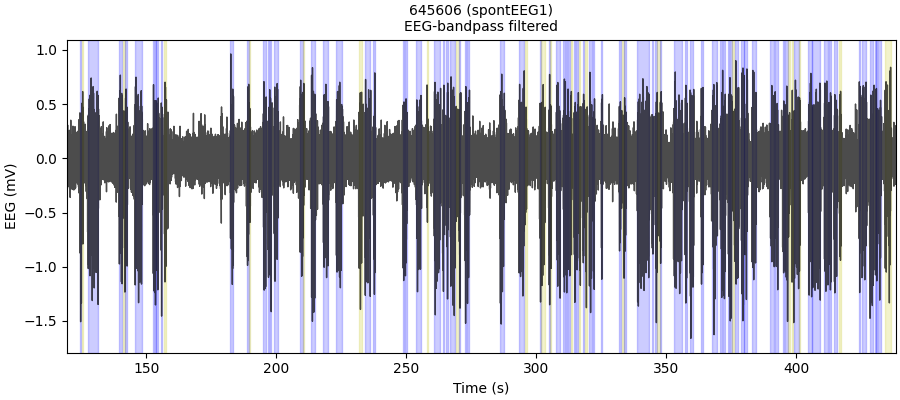

In [17]:
plot_ch = 18

fig, ax = plt.subplots(figsize=(9, 4), constrained_layout=True)
ax.plot(timex, filt_data[:, plot_ch], color='k', linewidth=1.0, alpha=0.7)
# ax.plot(timex, filt_data[:, 16], color='b', linewidth=1.0, alpha=0.7)
# ax.plot(timex, np.std(filt_data, axis=1), color='r', linewidth=1.0, alpha=0.7)
ax.set_xlim([timex[0], timex[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('EEG (mV)')
ax.set_title('{} ({})\nEEG-bandpass filtered'.format(exp.mouse, exp_tag))

for dfind, dfrow in man_annots.iterrows():
    if dfrow['description'] == 'SWD':
        evcol = 'b'
    elif dfrow['description'] == 'maybe':
        evcol = 'y'
    ax.axvspan(dfrow['onset'], dfrow['offset'], color=evcol, alpha=0.2)

<IPython.core.display.Javascript object>


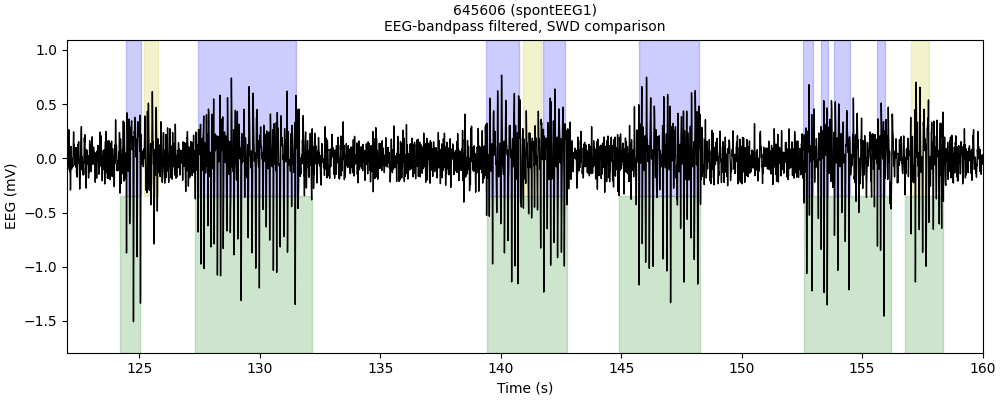

In [22]:
fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)
ax.plot(timex, filt_data[:, plot_ch], color='k', linewidth=1.0)
ax.set_xlim([122, 160])
ax.set_xlabel('Time (s)')
ax.set_ylabel('EEG (mV)')
ax.set_title('{} ({})\nEEG-bandpass filtered, SWD comparison'.format(exp.mouse, exp_tag))

for dfind, dfrow in man_annots.iterrows():
    if dfrow['description'] == 'SWD':
        evcol = 'b'
    elif dfrow['description'] == 'maybe':
        evcol = 'y'
    ax.axvspan(dfrow['onset'], dfrow['offset'], 0.5, 1, color=evcol, alpha=0.2)
    
for swdind, swdrow in autoSWD_df.iterrows():
    ax.axvspan(swdrow['onset'], swdrow['offset'], 0, 0.5, color='g', alpha=0.2)

### SAVE ###
fig_name = '{}_filtEEG_SWDs_ch{:d}.png'.format(exp_tag, plot_ch)
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

#### Define quiescent periods

In [23]:
adj_onsets = man_annots['onset'].values - 1
print(adj_onsets[:5])
adj_offsets = man_annots['offset'].values + 1
print(adj_offsets[:5])

[123.44544552 124.18350321 126.41870389 138.38347121 139.91592688]
[126.07645668 126.76944214 132.49774028 141.741272   142.68778874]


In [24]:
between_times = adj_onsets[1:] - adj_offsets[:-1]
print(between_times[:10])

[-1.89295346 -0.35073825  5.88573093 -1.82534513 -1.92112361  1.05626028
  2.3393102  -1.66195831 -1.75773679 -0.87319437]


In [25]:
qints = np.nonzero(between_times > 2)[0]
print(qints)
print(len(qints))

[ 2  6 11 12 14 18 23 26 38 39 41 58 61 66 80 94]
16


<IPython.core.display.Javascript object>


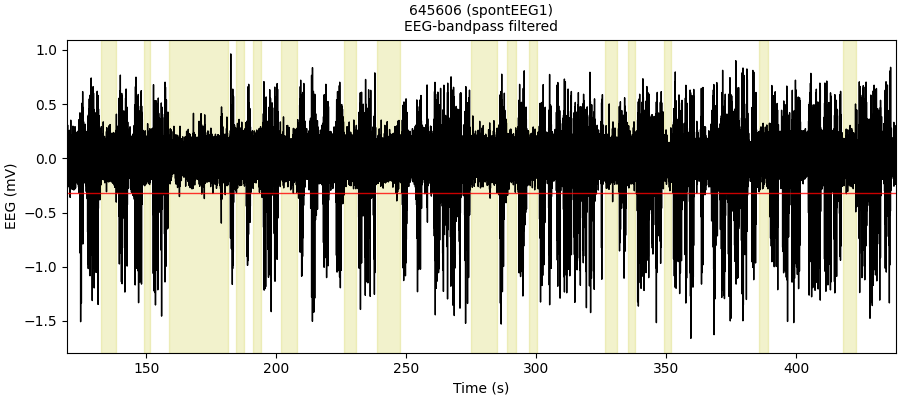

In [26]:
plot_ch = 18

fig, ax = plt.subplots(figsize=(9, 4), constrained_layout=True)
ax.plot(timex, filt_data[:, plot_ch], color='k', linewidth=1.0)
ax.set_xlim([timex[0], timex[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('EEG (mV)')
ax.set_title('{} ({})\nEEG-bandpass filtered'.format(exp.mouse, exp_tag))

notSWD_eegch = []
for indi in qints:
    ax.axvspan(adj_offsets[indi], adj_onsets[indi+1], color='y', alpha=0.2)
    tempinds = np.nonzero((timex > adj_offsets[indi]) & (timex < adj_onsets[indi+1]))[0]
    notSWD_eegch.append(filt_data[tempinds, plot_ch])
quiesc_eeg = np.concatenate(notSWD_eegch)
q_mean = np.mean(quiesc_eeg)
q_std = np.std(quiesc_eeg)
ax.axhline(q_mean - 3 * q_std, color='r', linewidth=1.0, alpha=0.8)

In [27]:
print(q_mean)
print(q_std)
print((q_mean + 3 * q_std))

7.994619464470531e-05
0.10663339737689935
0.3199801383253427


In [23]:
V_mean = np.mean(filt_data[:, plot_ch])
V_std = np.std(filt_data[:, plot_ch])
print(V_mean)
print(V_std)
print((V_mean + 2 * V_std))

-5.275326794419075e-06
0.22043726085555287
0.44086924638431135


### Can we use an auto threshold to find possible SWDs/quiescent periods to set a better threshold?

In [34]:
V_mean = np.mean(filt_data[:, plot_ch])
V_std = np.std(filt_data[:, plot_ch])
first_pkth = V_mean + 2 * V_std
first_peaks, pk_info = signal.find_peaks(-filt_data[:, plot_ch], first_pkth)
print(len(first_peaks))

774


Use initial threshold to find probable SWDs

In [38]:
spike_times = timex[first_peaks]

preISIs = np.insert(np.diff(spike_times), 0, spike_times[0] - timex[0])
postISIs = np.diff(spike_times)

## Loop through all spikes to find possible SWDs ##
SWD_list = []
spind = 0
while spind < len(spike_times):
    tempSWD = [spike_times[spind]]
    spind += 1
    while (spind < len(preISIs)) and (preISIs[spind] < 0.4):
        tempSWD.append(spike_times[spind])
        spind += 1
    if len(tempSWD) > 1:
        SWD_list.append(tempSWD)
    del tempSWD
print(len(SWD_list))

## Make dataframe ##
prob_SWD_info = []
for swdind in SWD_list:
    if swdind[-1]-swdind[0] > 0.5:
        prob_SWD_info.append([swdind[0], swdind[-1], swdind[-1]-swdind[0], len(swdind)])
prob_SWD_df = pd.DataFrame(prob_SWD_info, columns=['onset', 'offset', 'duration', 'spike count'])
prob_SWD_df.head()

77


,onset,offset,duration,spike count
0,124.467322,125.046523,0.579201,5
1,127.442926,131.586531,4.143605,29
2,139.412941,142.639745,3.226804,24
3,145.746149,146.320150,0.574001,5
4,147.466152,148.176552,0.710401,6


Find quiescent periods

In [39]:
adj_onsets = prob_SWD_df['onset'].values - 1
print(adj_onsets[:5])
adj_offsets = prob_SWD_df['offset'].values + 1
print(adj_offsets[:5])
between_times = adj_onsets[1:] - adj_offsets[:-1]
print(between_times[:10])
qints = np.nonzero(between_times > 2)[0]
print(len(qints))

[123.46732186 126.44292571 138.41294117 144.74614935 146.46615157]
[126.04652261 132.58653106 143.63974534 147.32015009 149.17655249]
[ 0.3964031   5.82641011  1.10640401 -0.85399852  2.52400584 -0.94239863
 -1.16639892 22.12883117  3.04000651  3.1868067 ]
17


Now find new threshold between probable SWDs

<IPython.core.display.Javascript object>


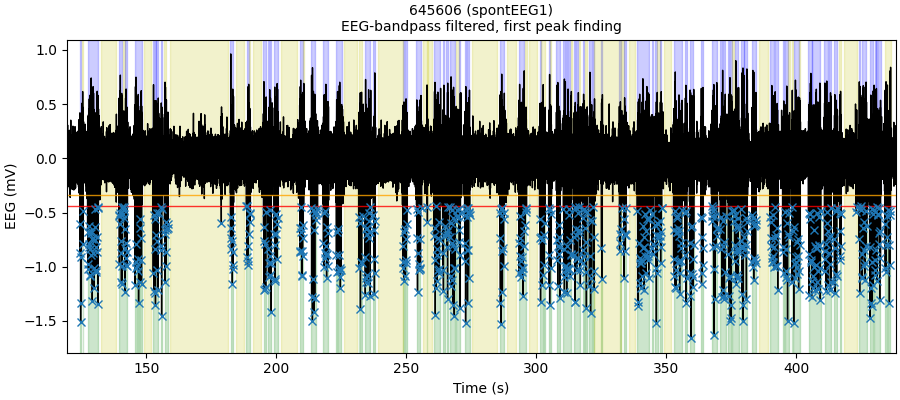

In [41]:
fig, ax = plt.subplots(figsize=(9, 4), constrained_layout=True)
ax.plot(timex, filt_data[:, plot_ch], color='k', linewidth=1.0)
ax.set_xlim([timex[0], timex[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('EEG (mV)')
ax.set_title('{} ({})\nEEG-bandpass filtered, first peak finding'.format(exp.mouse, exp_tag))
ax.axhline(V_mean - 2 * V_std, color='r', linewidth=1.0, alpha=0.8)
ax.plot(timex[first_peaks], filt_data[first_peaks, plot_ch], 'x')

for dfind, dfrow in man_annots.iterrows():
    if dfrow['description'] == 'SWD':
        evcol = 'b'
    elif dfrow['description'] == 'maybe':
        evcol = 'y'
    ax.axvspan(dfrow['onset'], dfrow['offset'], 0.5, 1, color=evcol, alpha=0.2)

for swdind in SWD_list:
    ax.axvspan(swdind[0], swdind[-1], 0, 0.5, color='g', alpha=0.2)

notSWD_eegch = []
for indi in qints:
    ax.axvspan(adj_offsets[indi], adj_onsets[indi+1], color='y', alpha=0.2)
    tempinds = np.nonzero((timex > adj_offsets[indi]) & (timex < adj_onsets[indi+1]))[0]
    notSWD_eegch.append(filt_data[tempinds, plot_ch])
qeeg = np.concatenate(notSWD_eegch)
q_mean = np.mean(qeeg)
q_std = np.std(qeeg)
ax.axhline(q_mean - 3 * q_std, color='orange', linewidth=1.0, alpha=0.8)

In [42]:
print(q_mean)
print(q_std)
print(q_mean + 3 * q_std)

5.429857950686579e-05
0.1139228936283384
0.34182297946452206


### Find peaks using quiescent voltage threshold (qVmean - 3 * qVstd)

In [28]:
pkthresh = q_mean + 3 * q_std

In [29]:
poss_peaks, pk_info = signal.find_peaks(-filt_data[:, plot_ch], height=pkthresh)
print(len(poss_peaks))

1012


<IPython.core.display.Javascript object>


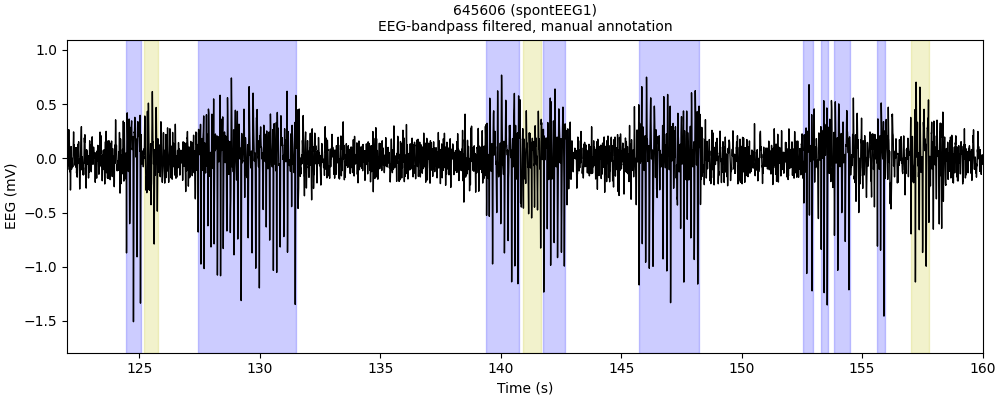

In [36]:
fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)
ax.plot(timex, filt_data[:, plot_ch], color='k', linewidth=1.0)
ax.set_xlim([122, 160])
ax.set_xlabel('Time (s)')
ax.set_ylabel('EEG (mV)')
ax.set_title('{} ({})\nEEG-bandpass filtered, peak finding'.format(exp.mouse, exp_tag))
ax.axhline(q_mean - 3 * q_std, color='r', linewidth=1.0, alpha=0.8)
ax.plot(timex[poss_peaks], filt_data[poss_peaks, plot_ch], 'x')

for dfind, dfrow in man_annots.iterrows():
    if dfrow['description'] == 'SWD':
        evcol = 'b'
    elif dfrow['description'] == 'maybe':
        evcol = 'y'
    ax.axvspan(dfrow['onset'], dfrow['offset'], color=evcol, alpha=0.2)

### SAVE ###
fig_name = '{}_filtEEG_ch{:d}_peaks.png'.format(exp_tag, plot_ch)
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

What if we iterate through all spikes?

In [46]:
# from above #
spike_times = timex[poss_peaks]

preISIs = np.insert(np.diff(spike_times), 0, spike_times[0] - timex[0])
postISIs = np.diff(spike_times)

In [47]:
## Loop through all spikes to find possible SWDs ##
SWD_list = []
spind = 0
while spind < len(spike_times):
    tempSWD = [spike_times[spind]]
    spind += 1
    while (spind < len(preISIs)) and (preISIs[spind] < 0.4):
        tempSWD.append(spike_times[spind])
        spind += 1
    if len(tempSWD) > 1:
        SWD_list.append(tempSWD)
    del tempSWD
print(len(SWD_list))

64


<IPython.core.display.Javascript object>


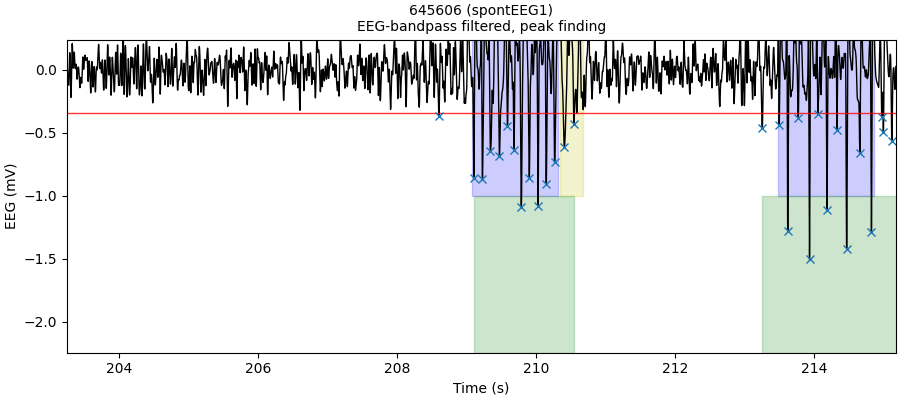

In [48]:
fig, ax = plt.subplots(figsize=(9, 4), constrained_layout=True)
ax.plot(timex, filt_data[:, plot_ch], color='k', linewidth=1.0)
ax.set_xlim([timex[0], timex[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('EEG (mV)')
ax.set_title('{} ({})\nEEG-bandpass filtered, peak finding'.format(exp.mouse, exp_tag))
ax.axhline(q_mean - 3 * q_std, color='r', linewidth=1.0, alpha=0.8)
ax.plot(timex[poss_peaks], filt_data[poss_peaks, plot_ch], 'x')

for dfind, dfrow in man_annots.iterrows():
    if dfrow['description'] == 'SWD':
        evcol = 'b'
    elif dfrow['description'] == 'maybe':
        evcol = 'y'
    ax.axvspan(dfrow['onset'], dfrow['offset'], 0.5, 1, color=evcol, alpha=0.2)
    
for swdind in SWD_list:
    ax.axvspan(swdind[0], swdind[-1], 0, 0.5, color='g', alpha=0.2)

### Make SWD event table

In [50]:
SWD_info = []
for swdind in SWD_list:
    if swdind[-1]-swdind[0] > 0.5:
        SWD_info.append([swdind[0], swdind[-1], swdind[-1]-swdind[0], len(swdind), swdind])
SWD_df = pd.DataFrame(SWD_info, columns=['onset', 'offset', 'duration', 'spike_count', 'SWD_spike_times'])
SWD_df.head()

,onset,offset,duration,spike_count,SWD_spike_times
0,124.467322,125.046523,0.579201,5,"[124.46732186149704, 124.59812203045982, 124.7..."
1,127.321726,132.150932,4.829206,33,"[127.32172554870921, 127.44292570527105, 127.5..."
2,139.412941,142.752145,3.339204,26,"[139.4129411676904, 139.52534131288473, 139.66..."
3,145.409749,148.291353,2.881604,20,"[145.40974891414288, 145.6253491926473, 145.74..."
4,152.581758,156.198563,3.616805,23,"[152.58175817867686, 152.70055833213848, 152.8..."


In [57]:
auto_annot_file = os.path.join(exp.data_folder, r'test_autoSWDannots_first5min.pkl')
SWD_df.to_pickle(auto_annot_file)

## Must save df as a pickle file to recover the list of spike times

In [58]:
if os.path.exists(auto_annot_file):
    print(r'Whoopee')
    test_annots = pd.read_pickle(auto_annot_file)
else:
    print(r'Oops, no')

Whoopee


In [59]:
test_annots.head()

,onset,offset,duration,spike_count,SWD_spike_times
0,124.467322,125.046523,0.579201,5,"[124.46732186149704, 124.59812203045982, 124.7..."
1,127.321726,132.150932,4.829206,33,"[127.32172554870921, 127.44292570527105, 127.5..."
2,139.412941,142.752145,3.339204,26,"[139.4129411676904, 139.52534131288473, 139.66..."
3,145.409749,148.291353,2.881604,20,"[145.40974891414288, 145.6253491926473, 145.74..."
4,152.581758,156.198563,3.616805,23,"[152.58175817867686, 152.70055833213848, 152.8..."


In [61]:
test_val = test_annots['onset'].values[0]
print(test_val)
print(type(test_val))

124.46732186149704
<class 'numpy.float64'>
